# Lab | Imbalanced data

We will be using the `files_for_lab/customer_churn.csv` dataset to build a churn predictor.

### Instructions

1. Load the dataset and explore the variables.
2. We will try to predict variable `Churn` using a logistic regression on variables `tenure`, `SeniorCitizen`,`MonthlyCharges`.
3. Split the Dataset into X ('tenure', 'SeniorCitizen', 'MonthlyCharges') and y ('Churn')
4. Build the logistic regression model.
5. Evaluate the model.
6. Even a simple model will give us more than 70% accuracy. Why?
7. **Synthetic Minority Oversampling TEchnique (SMOTE)** is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply `imblearn.over_sampling.SMOTE` to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import model_functions as mf
import data_cleaning_functions as dc

import pickle

## 1. Load the dataset and explore the variables.

In [2]:
data = pd.read_csv('files_for_lab/customer_churn.csv')

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.isna().sum()/data.shape[0]

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

## 2. We will try to predict variable `Churn` using a logistic regression on variables `tenure`, `SeniorCitizen`,`MonthlyCharges`.

## 3. Split the Dataset into X ('tenure', 'SeniorCitizen', 'MonthlyCharges') and y ('Churn')


In [5]:
data = data[['Churn','tenure','SeniorCitizen','MonthlyCharges']]
y = data[['Churn']]
X = data.drop(['Churn'],axis=1)

In [6]:
X['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [7]:
#Since 'SeniorCitizen' appears to be a categorical boolean column, I changed the datatype to object.
X['SeniorCitizen']=X['SeniorCitizen'].astype(object)

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   SeniorCitizen   7043 non-null   object 
 2   MonthlyCharges  7043 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 165.2+ KB


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train_num = X_train.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object)
X_test_num = X_test.select_dtypes(np.number)
X_test_cat = X_test.select_dtypes(object)

I am checking the distribution of the numerical columns and applying a power transformation.

'Skew from tenure is:0.24'

'Skew from MonthlyCharges is:-0.23'

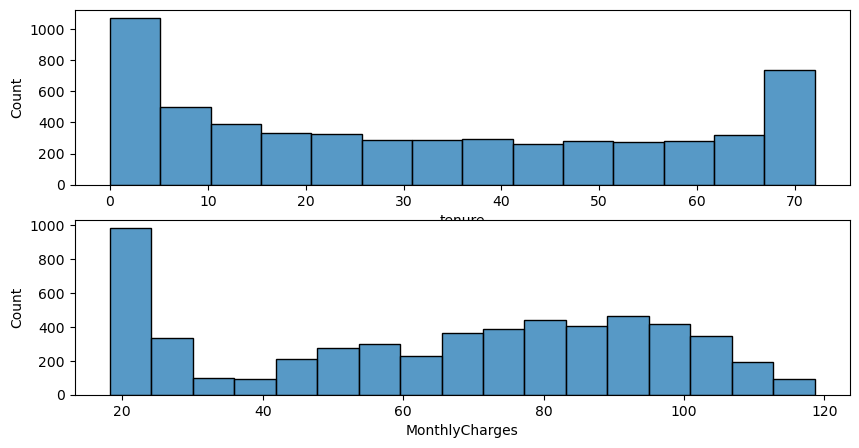

In [11]:
fix, ax=plt.subplots(2,1,figsize=(10,5))
sns.histplot(x=X_train_num['tenure'], ax=ax[0])
sns.histplot(x=X_train_num['MonthlyCharges'], ax=ax[1])
display("Skew from tenure is:{:.2f}".format(X_train_num['tenure'].skew()))
display("Skew from MonthlyCharges is:{:.2f}".format(X_train_num['MonthlyCharges'].skew()))

In [12]:
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer(standardize=True)
transformer.fit(X_train_num) # we will reuse this transformer for X_test later

path = "./"
filename = "power_transformer.pkl"

with open(path+filename, "wb") as file:
    pickle.dump(transformer, file)

X_train_transformed = transformer.transform(X_train_num)
X_test_transformed  = transformer.transform(X_test_num)
X_train_num_transformed_df = pd.DataFrame(X_train_transformed, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_transformed_df  = pd.DataFrame(X_test_transformed,  columns=X_test_num.columns, index=X_test_num.index)
#X_train_num_transformed_df.head()
X_train_num_transformed_df.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
tenure,5634.0,0.0,1.0,-2.0,-1.0,0.0,1.0,1.0
MonthlyCharges,5634.0,0.0,1.0,-2.0,-1.0,0.0,1.0,2.0


'Skew from tenure is:-0.24'

'Skew from MonthlyCharges is:-0.26'

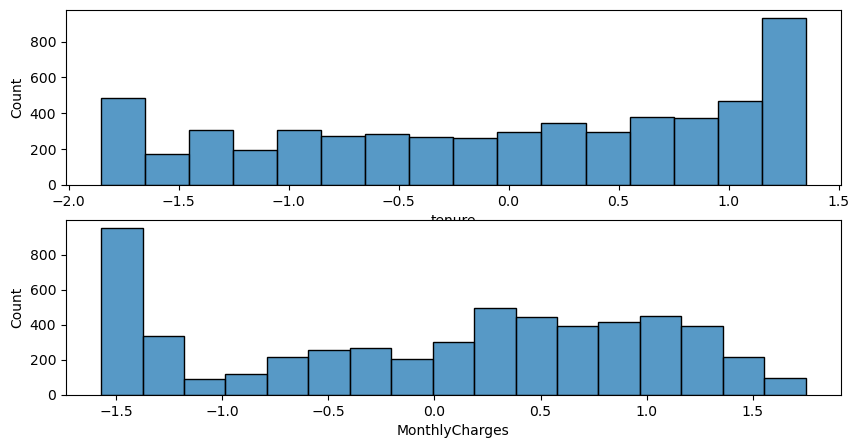

In [13]:
fix, ax=plt.subplots(2,1,figsize=(10,5))
sns.histplot(x=X_train_num_transformed_df['tenure'], ax=ax[0])
sns.histplot(x=X_train_num_transformed_df['MonthlyCharges'], ax=ax[1])
display("Skew from tenure is:{:.2f}".format(X_train_num_transformed_df['tenure'].skew()))
display("Skew from MonthlyCharges is:{:.2f}".format(X_train_num_transformed_df['MonthlyCharges'].skew()))

I'm checking the distribution of the categorical columns as well.

<Axes: xlabel='count', ylabel='Churn'>

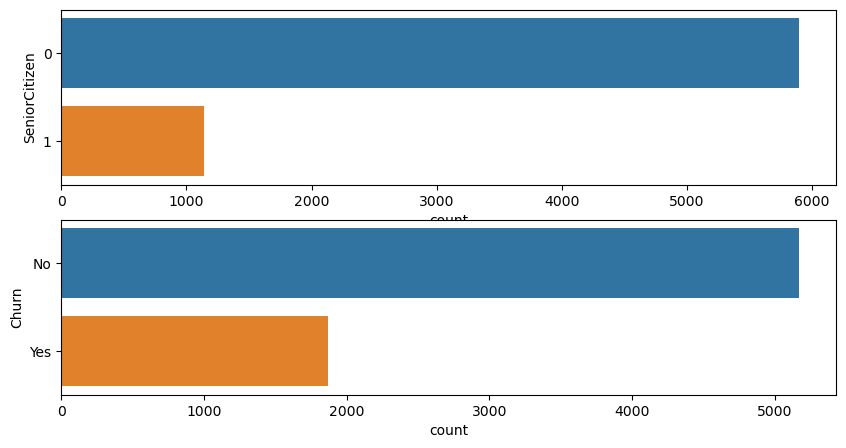

In [14]:
fix, ax=plt.subplots(2,1,figsize=(10,5))
sns.countplot(y=X['SeniorCitizen'], order=X['SeniorCitizen'].value_counts().index, ax=ax[0])
sns.countplot(y=y['Churn'], order=y['Churn'].value_counts().index, ax=ax[1])

I observe a significant class imbalance in both the 'SeniorCitizen' and the target column 'Churn.'

I dont have to use a OneHotEncoder, because i already have boolean values. 

In [15]:
X_train_treated_df = pd.concat([X_train_num_transformed_df, X_train_cat], axis=1)
X_test_treated_df  = pd.concat([X_test_num_transformed_df, X_test_cat], axis=1)

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_treated_df)

path = "./"
filename = "min_max_scaler.pkl"
with open(path+filename, "wb") as file:
    pickle.dump(scaler, file)

X_train_scaled = scaler.transform(X_train_treated_df)
X_test_scaled  = scaler.transform(X_test_treated_df)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_treated_df.columns)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=X_test_treated_df.columns)
X_train_scaled_df.head()
X_train_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,5634.0,0.578458,0.312183,0.0,0.308048,0.613842,0.868285,1.0
MonthlyCharges,5634.0,0.473124,0.301344,0.0,0.184175,0.534317,0.724309,1.0
SeniorCitizen,5634.0,0.160809,0.367388,0.0,0.000000,0.000000,0.000000,1.0


## 4. Build the logistic regression model.


In [17]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr')

classification.fit(X_train_scaled_df, y_train)

C:\Users\schue\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(multi_class='ovr', random_state=0)

## 5. Evaluate the model.


In [18]:
y_train_pred = classification.predict(X_train_scaled_df)
y_test_pred  = classification.predict(X_test_scaled_df)

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score

The confusion matrix on the TRAIN set is: 


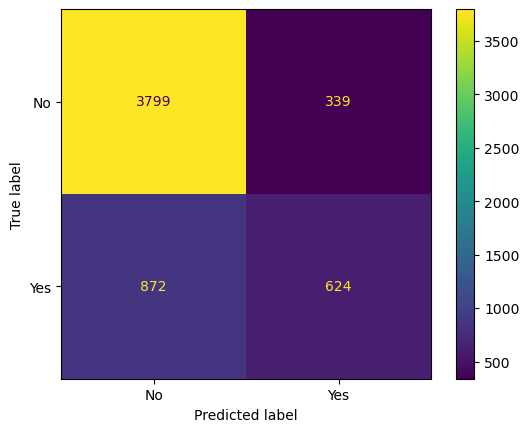

In [20]:
print("The confusion matrix on the TRAIN set is: ")
cm_train = confusion_matrix(y_train, y_train_pred)
cm_train
disp = ConfusionMatrixDisplay(cm_train, display_labels=classification.classes_);
disp.plot()
plt.show()

In [21]:
print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
print("The F1-score for the TRAIN set is {:.2f}".format(f1_score(y_train,y_train_pred, pos_label='Yes')))
print("The recall in the TRAIN set is: {:.3f}".format(recall_score(y_train, y_train_pred, pos_label='Yes')))
print("The precission in the TRAIN set is: {:.3f}".format(precision_score(y_train, y_train_pred, pos_label='Yes')))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_train,y_train_pred)))

The accuracy in the TRAIN set is: 0.785
The F1-score for the TRAIN set is 0.51
The recall in the TRAIN set is: 0.417
The precission in the TRAIN set is: 0.648
The Kappa in the TEST set is: 0.38


The confusion matrix on the TEST set is: 
[[963  73]
 [205 168]]


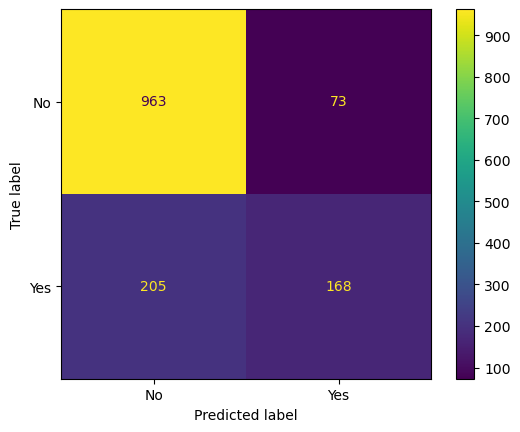

In [22]:
print("The confusion matrix on the TEST set is: ")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_);
disp.plot()
plt.show()

In [23]:
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred)))
print("The F1-score for the TEST set is {:.2f}".format(f1_score(y_test,y_test_pred, pos_label='Yes')))
print("The recall in the TEST  set is: {:.3f}".format(recall_score(y_test,  y_test_pred, pos_label='Yes')))
print("The precission in the TEST  set is: {:.3f}".format(precision_score(y_test, y_test_pred, pos_label='Yes')))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_test_pred)))

The accuracy in the TEST  set is: 0.803
The F1-score for the TEST set is 0.55
The recall in the TEST  set is: 0.450
The precission in the TEST  set is: 0.697
The Kappa in the TEST set is: 0.43


We are better in predictiong the positives ('Yes') with an percentage of 64,8%/69,7% for the train and for the test set.

Our prediction for the negatives ('No') is not more worse with an percentage of 41,7%/45% for the train and the test set.

In [24]:
CI_train = (y_train.value_counts()[1]-y_train.value_counts()[0])/((y_train.value_counts()[1]+y_train.value_counts()[0]))
print(CI_train)
CI_test = (y_test.value_counts()[1]-y_test.value_counts()[0])/((y_test.value_counts()[1]+y_test.value_counts()[0]))
print(CI_test)

-0.46893858714944975
-0.47054648687012063


We have a high class imbalance with 46%. The optimal value would be 0%.

## 6. Even a simple model will give us more than 70% accuracy. Why?

Because of the high class imbalance. The model is predicting more churn=no then churn= yes. So even when the model will predict allways churn=no, the percentage of right predictions will be high. It's more a matter of luck. The reasonause the model has less informations about the citizens who are churning. 

## 7. **Synthetic Minority Oversampling TEchnique (SMOTE)** is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply `imblearn.over_sampling.SMOTE` to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

In [25]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=100,k_neighbors=3)

X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_scaled_df,y_train)

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_test = lr.predict(X_test_scaled_df)
y_pred_train = lr.predict(X_train_scaled_df)

C:\Users\schue\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The confusion matrix on the TEST-SMOTE set is: 


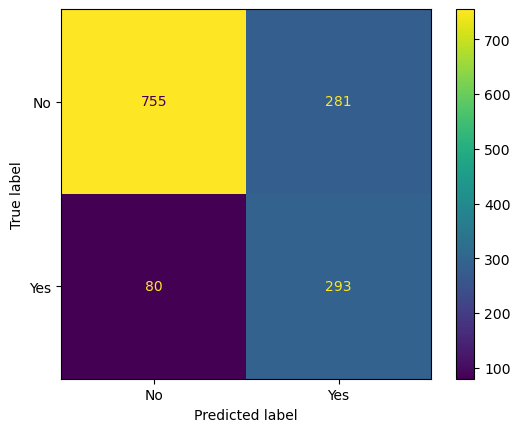

In [27]:
print("The confusion matrix on the TEST-SMOTE set is: ")
cm_test = confusion_matrix(y_test,y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()

In [33]:
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_pred_test)))
print("The F1-score for the TEST set is {:.2f}".format(f1_score(y_test,y_pred_test, pos_label='Yes')))
print("The recall in the TEST  set is: {:.3f}".format(recall_score(y_test,  y_pred_test, pos_label='Yes')))
print("The precission in the TEST  set is: {:.3f}".format(precision_score(y_test, y_pred_test, pos_label='Yes')))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TEST  set is: 0.744
The F1-score for the TEST set is 0.62
The recall in the TEST  set is: 0.786
The precission in the TEST  set is: 0.510
The Kappa in the TEST set is: 0.44


In [34]:
print("The accuracy in the TRAIN  set is: {:.3f}".format(accuracy_score(y_train, y_pred_train)))
print("The F1-score for the TRAIN set is {:.2f}".format(f1_score(y_train,y_pred_train, pos_label='Yes')))
print("The recall in the TRAIN  set is: {:.3f}".format(recall_score(y_train,  y_pred_train, pos_label='Yes')))
print("The precission in the TRAIN  set is: {:.3f}".format(precision_score(y_train, y_pred_train, pos_label='Yes')))
print("The Kappa in the TRAIN set is: {:.2f}".format(cohen_kappa_score(y_train,y_pred_train)))

The accuracy in the TRAIN  set is: 0.730
The F1-score for the TRAIN set is 0.59
The recall in the TRAIN  set is: 0.739
The precission in the TRAIN  set is: 0.494
The Kappa in the TRAIN set is: 0.40


In [29]:
CI_train = (y_train_SMOTE.value_counts()[1]-y_train_SMOTE.value_counts()[0])/((y_train_SMOTE.value_counts()[1]+y_train_SMOTE.value_counts()[0]))
print(CI_train)

0.0


The class imbalance (CI) has reduced to 0%, and this outcome is attributed to the oversampling process.

The accuracy has decreased compared to the previous state, mainly because we have introduced additional information about individuals who are churning. Consequently, predicting accurately becomes more challenging compared to simply predicting the same outcome consistently (a matter of luck).

The values of precision and recall have undergone a swap. Post-SMOTE, recall becomes greater than precision in both the training and test sets.

The Kappa value shows only a slight increase, from 0.43 to 0.44 in the test set and from 0.38 to 0.4 in the training set. However, it still falls within the category of "fair to moderate agreement."